# Imports

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import HTML as html_print

# Install with:
#     pip install logomaker
import logomaker

# Printing and visualization

## Print motif in text

In [9]:
def print_motif(motif):
    """
    Print the motif array nicely.
    """
    with np.printoptions(precision=3, suppress=True):
        print(motif)

## Draw motif with logomaker

In [115]:
def draw_motif(motif, title=""):
    """
    Draw a logo of the motif with logomaker.
    """
    # Make dataframe for logomake
    df = pd.DataFrame(motif, columns=["A", "C", "G", "T"])
    df = logomaker.transform_matrix(df, from_type="probability", to_type="information")
    logo = logomaker.Logo(df)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        logo.ax.set_title(title)
        logo.ax.set_xlabel("Position")
        logo.ax.set_ylabel("Total information")
        logo.ax.set_ylim(0, np.log2(4))
        logo.fig.show()


In [92]:
def cstr(s, color='black'):
    return "<text style='color:{};font-family:monospace;font-size:1em'>{}</text>".format(color, s)

def draw_sequences(sequences, positions=None):
    # Convert sequences to text
    text = ""
    for n in range(len(sequences)):
        row = ""
        for s in sequences[n]:
            row += "ACGT"[s]
        row += "\n"
        
        # If no positions to show, everything is black
        if positions is None:                  
            row = cstr(row, color='black')
    
        # Otherwise, color in red
        else:
            pos = positions[n]
            row = \
                cstr(row[:pos], color="black") + \
                cstr(row[pos:pos+motif_length], color="red") + \
                cstr(row[pos+motif_length:], color="black")               
        
        
        text += row
    
    display(html_print(text))


# Parameters of the problem


In [158]:
# Those are global variables to be used throughout the notebook
num_sequences = 90
sequence_length = 100
motif_length = 8
alpha = 0.1

### Initialize the random number generator

In [29]:
random_seed = 42
rng = np.random.default_rng(random_seed)

# Generate the data

## Data generating functions

In [126]:
def sample_motif(motif_length=motif_length, alpha=alpha):
    """
    Draw a motif from the dirichlet distribution.
    """
    return rng.dirichlet([alpha] * 4, motif_length)


        
def sample_sequence_from_motif(motif):
    """
    Draw a subsequence from the distribution defined by the motif, and return it.
    """
    # Initialize the sequence array
    motif_sequence = np.zeros(motif_length, dtype=int)

    # Draw each sequence element from motif
    for k in range(motif_length):
        motif_sequence[k] = rng.choice(4, size=1, p=motif[k, :])

    return motif_sequence
    
    
    
def generate_sequences(motif):
    """
    Draw a set of sequences, with a single motif subsequence embedded.
    """        
    # Initialize the sequences matrix
    sequences = rng.integers(4, size=(num_sequences, sequence_length))

    # Draw positions for motifs
    positions = rng.integers(sequence_length - motif_length + 1, size=num_sequences)

    # Per full sequence, draw from motif and insert
    for n in range(num_sequences):
        sequences[n, positions[n]:positions[n] + motif_length] = sample_sequence_from_motif(motif)
            
    return sequences, positions



## An example of data generation

In [159]:
M = sample_motif()
sequences, positions = generate_sequences(M)

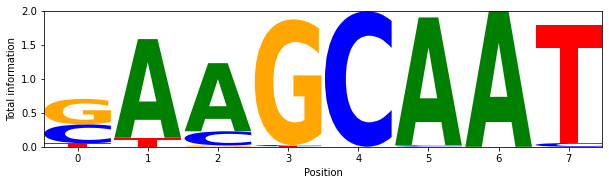

In [160]:
draw_motif(M)    

In [161]:
draw_sequences(sequences[:20], positions)

# Expectation-Maximization

## Calculate log-likelihood of data

In [162]:
def log_likelihood(
    sequences,
    motif
):
    """
    Calculate the log-likehood of the sequences given the motif, 
    integrating over all positions.
    """
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    C = (1.0 / max_position) * (1.0/4)**(sequence_length - motif_length)
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        for i in range(max_position):
            q = C
            for k in range(motif_length):
                q *= motif[k, sequences[n, i + k]] 
            p += q
        ll += np.log(p)
                        
    return ll
        

## Expectation step

In [163]:
def expectation_step(
    sequences,
    motif
):
    # Initialize
    max_position = sequence_length - motif_length + 1
    positions_posterior = np.zeros((num_sequences, max_position), dtype=float)
    
    # Per sequence, calculate the posterior
    for n in range(num_sequences):
        # Calculate the likelihood of each k-mer in the sequence 
        for i in range(max_position):
            likelihood = 1.0
            for k in range(motif_length):
                likelihood *= motif[k, sequences[n, i + k]]
            positions_posterior[n, i] = likelihood
            
        # Normalize
        positions_posterior[n, :] /= positions_posterior[n, :].sum()
        
    return positions_posterior
    

## Maximization step

In [164]:
def maximization_step(
    sequences,
    positions_posterior,
):
    # Initialize
    max_position = sequence_length - motif_length + 1
    motif_estimate = np.zeros((motif_length, 4), dtype=float)   
    
    # Add dirichlet prior
    motif_estimate += alpha
    
    # Build the estimate
    for k in range(motif_length):
        for n in range(num_sequences):
            for i in range(max_position):
                # Which nucleotide is in the k-th position of the i-th k-mer 
                # in the n-th sequence?
                j = sequences[n, i+k]
                
                # Update the respective estimate
                motif_estimate[k, j] += positions_posterior[n, i]
                
        # Normalize
        motif_estimate[k, :] /= motif_estimate[k, :].sum()
                
    return motif_estimate
        
    

## EM algorithm

In [165]:
def expectation_maximization(
    sequences,
    n_iterations,
    print_every=None,
):
    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Iterate E and M steps
    lls = []
    positions_posterior_matrices = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        ll = log_likelihood(sequences, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
        
        # E step
        positions_posterior = expectation_step(sequences, est_motif)
        positions_posterior_matrices.append(positions_posterior)
        
        # M step
        est_motif = maximization_step(sequences, positions_posterior)
    
    return est_motif, lls, positions_posterior_matrices

## Run it!

In [166]:
est_motif, lls, positions_posterior_matrices = expectation_maximization(sequences, 100, print_every=10)

Iteration 0: LL = -12471.440384410167
Iteration 10: LL = -12098.131625021537
Iteration 20: LL = -12098.131624948754
Iteration 30: LL = -12098.131624948754
Iteration 40: LL = -12098.131624948754
Iteration 50: LL = -12098.131624948754
Iteration 60: LL = -12098.131624948754
Iteration 70: LL = -12098.131624948754
Iteration 80: LL = -12098.131624948754
Iteration 90: LL = -12098.131624948754


# MCMC

In [136]:
def log_likelihood_with_positions(
    sequences,
    positions,
    motif,
):
    # Initialize
    ll = 0.0
    max_position = sequence_length - motif_length + 1
    
    # Per sequence, add the log-likelihood
    for n in range(num_sequences):
        p = 0.0
        i = positions[n]
        q = 1
        for k in range(motif_length):
            q *= motif[k, sequences[n, i + k]] 
        p += q
        ll += np.log(p)
                        
    return ll

In [137]:
def gibbs_sample_position(
    sequences,
    est_motif,
    rng,
):
    max_position = sequence_length - motif_length + 1

    # Draw new positions
    positions_posterior = expectation_step(sequences, est_motif)
    positions = np.zeros(len(sequences), dtype=int)
    for n in range(num_sequences):
        positions[n] = rng.choice(max_position, p=positions_posterior[n])
        
    return positions


In [140]:
def calculate_dirichlet_parameters(
    alpha,
    sequences,
    est_positions,
    motif_length,
):
    max_position = sequence_length - motif_length + 1
    
    # Calculate the dirichelt parameters
    dirichlet_parameters = np.ones((motif_length, 4), dtype=float) * alpha    
    for k in range(motif_length):
        for n in range(num_sequences):
            c = sequences[n, est_positions[n] + k]
            dirichlet_parameters[k,c] += 1            
    
    return dirichlet_parameters
    

In [139]:
def gibbs_sample_motif(
    alpha,
    sequences,
    est_positions,
    motif_length,
    rng,
):
    max_position = sequence_length - motif_length + 1
    
    # Calculate the dirichelt parameters
    dirichlet_parameters = calculate_dirichlet_parameters(
        alpha,
        sequences,
        est_positions,
        motif_length,
    )            
    
    # Draw new motif from this distribution
    est_motif = np.zeros((motif_length, 4), dtype=float)
    for k in range(motif_length):
        est_motif[k, :] = rng.dirichlet(dirichlet_parameters[k])
        
    return est_motif
    

In [145]:
def metropolis_hastings_step(
    sequences,
    est_positions,
    est_motif,    
    current_ll,
    max_position,
    rng,
):
    # Make new state
    if rng.random() < 0.5:
        # abcdefgh -> habcdefg
        new_motif = np.roll(est_motif, 1, axis=0)
        new_positions = (est_positions - 1) % max_position
    else:
        # abcdefgh -> bcdefgha
        new_motif = np.roll(est_motif, -1, axis=0)
        new_positions = (est_positions + 1) % max_position
        
    # Calculate likelihood of new state
    new_ll = log_likelihood_with_positions(sequences, new_positions, new_motif)
    
    # Acceptance ratio
    acceptance_ratio = min(1.0, np.exp(new_ll - current_ll))
    
    # Accept if needed
    if rng.random() < acceptance_ratio:
        return new_motif, new_positions, True
    else:
        return est_motif, est_positions, False
        

In [148]:
def mcmc_sampling(
    sequences,
    motif_length,
    alpha,
    n_iterations,
    with_shifts=True,
    print_every=None,
):
    # Initialize the motif estimate randomly
    est_motif = rng.random(size=(motif_length, 4))
    est_motif /= est_motif.sum(axis=1)[:, np.newaxis]
    
    # Initialize positions
    max_position = sequence_length - motif_length + 1
    est_positions = rng.integers(max_position, size=num_sequences)
        
    # MCMC iterations
    lls = []
    states = []
    all_shifted = []
    for n_iter in range(n_iterations):
        # Print current log-likelihood
        states.append([est_motif, est_positions])
        ll = log_likelihood_with_positions(sequences, est_positions, est_motif)
        lls.append(ll)
        if (print_every is not None) and (n_iter % print_every == 0):
            print(f"Iteration {n_iter}: LL = {ll}")
            
        # Draw new positions
        est_positions = gibbs_sample_position(sequences, est_motif, rng)
        
        # Draw new motif
        est_motif = gibbs_sample_motif(
            alpha,
            sequences,
            est_positions,
            motif_length,
            rng,
        )
        
        # Possible shift
        if with_shifts:
            est_motif, est_positions, shifted = metropolis_hastings_step(
                sequences,
                est_positions,
                est_motif,    
                ll,
                max_position,
                rng,
            )
            all_shifted.append(shifted)
        
    return lls, all_shifted, states
    

    

## Run it!

In [151]:
lls, all_shifted, states = mcmc_sampling(
    sequences,
    K,
    alpha,
    1000,
    with_shifts=True,
    print_every=100,
)

Iteration 0: LL = -1082.6698011258447
Iteration 100: LL = -142.19557900349406
Iteration 200: LL = -150.87513469081338
Iteration 300: LL = -139.53381366793988
Iteration 400: LL = -140.58182575908856
Iteration 500: LL = -138.40376602322175
Iteration 600: LL = -139.3940582918625
Iteration 700: LL = -140.1248579561142
Iteration 800: LL = -146.59923418650172
Iteration 900: LL = -137.5404761133705
